# Prédiction des coûts Azure avec Prophet

Ce notebook a pour objectif de prévoir les coûts des services Azure sur les prochains mois à partir des données historiques disponibles.
Pour cela, nous utilisons Prophet, un modèle de série temporelle développé par Facebook, particulièrement adapté aux données présentant des tendances et une certaine saisonnalité.

L’analyse se déroule en plusieurs étapes :

Préparation des données : formatage et agrégation des coûts par date.

Entraînement du modèle Prophet sur les données passées.

Génération de prévisions pour les mois à venir.

Visualisation des tendances et des intervalles d’incertitude.

Ce travail permet d’anticiper les évolutions des dépenses cloud, et peut être utilisé pour mieux planifier les budgets ou détecter des anomalies futures.



### Mise en place d'un modèle de prédiction

In [1]:

import pandas as pd

df = pd.read_csv("/Users/thomaszilliox/Desktop/Bureau - MacBook Pro de Thomas/Doc Bureau/Etudes optimisation/Etude de cas FinOps et AI/Données fictives Azure Cost Management.csv",sep=";", quotechar='"')
print(df.head())


    UsageDate              ServiceName      CostUSD         Cost Currency
0  01/04/2024      Application Gateway  3728,351928  3213,558599      EUR
1  01/04/2024  Azure Analysis Services  1273,883324  1023,395045      EUR
2  01/04/2024        Azure App Service  18360,68594  16420,31301      EUR
3  01/04/2024                Azure Arc  4609,385175    4310,8096      EUR
4  01/04/2024     Azure Container Apps  28,60582862   25,6520558      EUR


In [11]:
df['Cost'] = df['Cost'].astype(float)
df['UsageDate'] = pd.to_datetime(df['UsageDate'])
df['ServiceName'] = df['ServiceName'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UsageDate    49 non-null     datetime64[ns]
 1   ServiceName  49 non-null     object        
 2   CostUSD      49 non-null     object        
 3   Cost         49 non-null     float64       
 4   Currency     49 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.0+ KB


In [ ]:
from prophet import Prophet

10:38:09 - cmdstanpy - INFO - Chain [1] start processing


10:38:10 - cmdstanpy - INFO - Chain [1] done processing


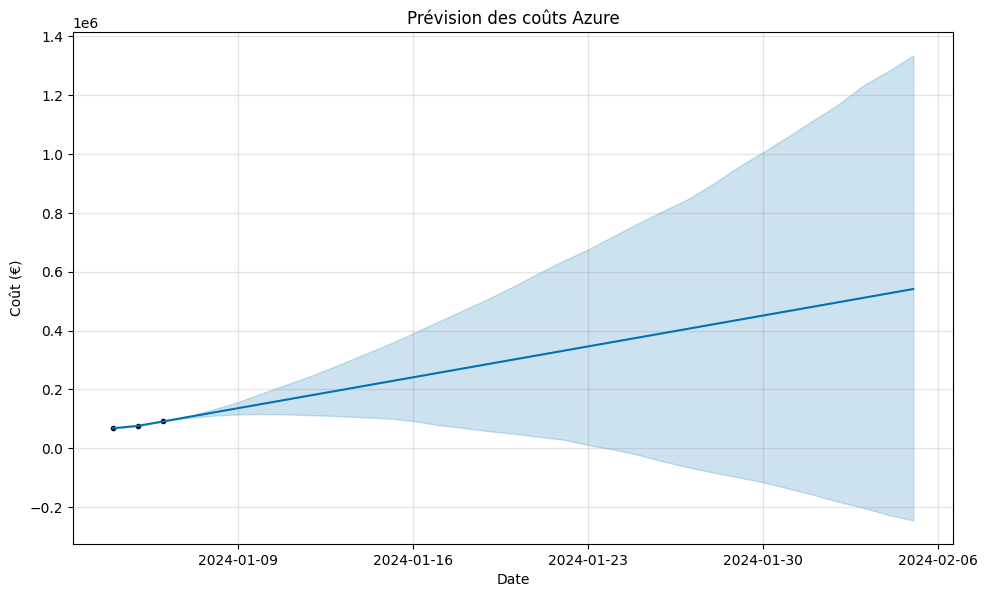

In [13]:
# 1. Importe le module matplotlib pour la visualisation
import matplotlib.pyplot as plt

# 2. Agrège les coûts par jour
df_daily = df.groupby("UsageDate").agg({"Cost": "sum"}).reset_index()

# 3. Renomme les colonnes pour Prophet
df_daily.columns = ["ds", "y"]

# 4. Initialise et entraîne le modèle Prophet
model = Prophet()
model.fit(df_daily)

# 5. Crée un dataframe pour 30 jours futurs
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 6. Visualise les prévisions
fig = model.plot(forecast)
plt.title("Prévision des coûts Azure")
plt.xlabel("Date")
plt.ylabel("Coût (€)")
plt.show()

Grâce à ce graphique généré grâce au module Prophet, nous pouvons voir que les coûts de Azure sont en augmentation au fur et à mesure des mois. Si cela continue, les coûts pourraient continuer à augmenter, il faudrait donc rapidement réaliser un audit pour observer d'où proviennent l'augmentation de ces coûts et comment les optimiser.

### Mise en place d'un agent à l'aide de Langchain

In [8]:
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents.agent_types import AgentType


In [ ]:
# Définit la fonction pour obtenir les services Azure les plus coûteux, réutilisable par l'agent

def get_top_costs(n=3, UsageDate="2025-07"):
    df = pd.read_csv("/Users/thomaszilliox/Desktop/***")
    df = df[df["UsageDate"] == UsageDate]
    df_sorted = df.sort_values(by="Cost", ascending=False).head(n)
    result = "\n".join([f"{row['Service']} : {row['Cost']}€" for _, row in df_sorted.iterrows()])
    return f"Top {n} services Azure les plus coûteux pour {UsageDate} :\n{result}"

In [ ]:
# Définis l'outil que l'agent pourra utiliser
cost_tool = Tool(
    name="TopAzureCosts",
    func=lambda x: get_top_costs(),  # pas encore dynamique
    description="Utilisé pour obtenir les services Azure les plus chers du mois"
)

api_key = "sk-proj-c*******************"  # Remplacez par votre clé API OpenAI
# Initialise l’agent avec GPT-4 ou GPT-3.5
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo",api_key=api_key)  # ou "gpt-3.5-turbo"

agent = initialize_agent(
    tools=[cost_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# Interroge l’agent
query = "Quels sont les services Azure les plus coûteux ce mois-ci ?"
response = agent.run(query)
print(response)
